In [11]:
# Statistical Analysis Pipeline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import logit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter("ignore")

In [12]:
import statsmodels.api as sm
print(sm.__version__)

0.14.5


In [13]:
df = pd.read_csv(r'C:\Users\asd\Desktop\Diabetes-Prediction\data\processed\cleaned.csv')

In [14]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


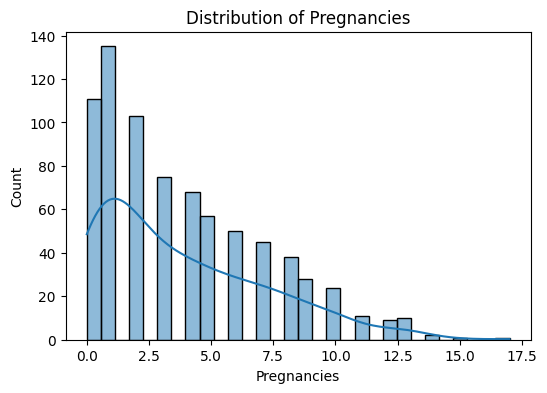

Pregnancies — Shapiro-Wilk p-value: 0.0000 (Not Normal)


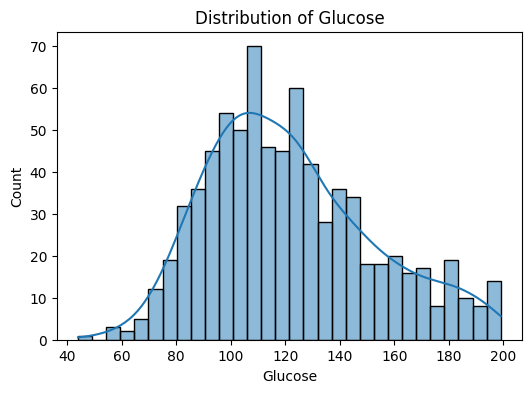

Glucose — Shapiro-Wilk p-value: 0.0000 (Not Normal)


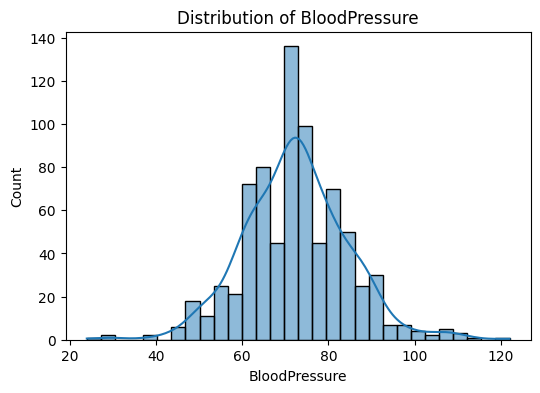

BloodPressure — Shapiro-Wilk p-value: 0.0000 (Not Normal)


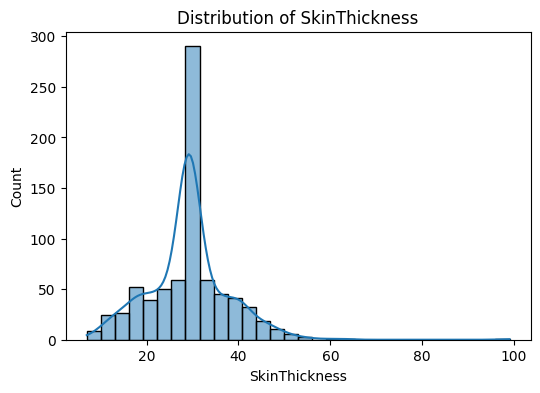

SkinThickness — Shapiro-Wilk p-value: 0.0000 (Not Normal)


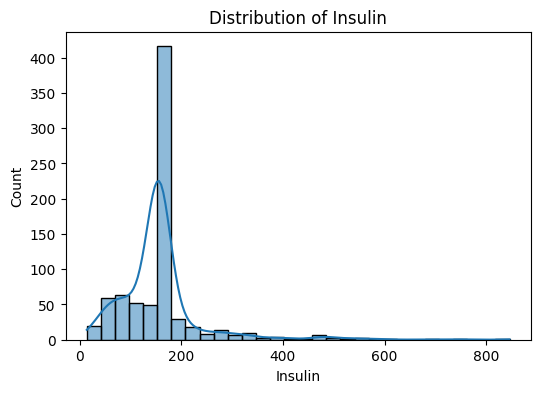

Insulin — Shapiro-Wilk p-value: 0.0000 (Not Normal)


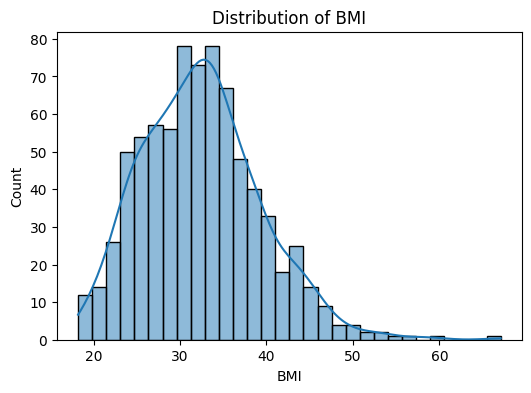

BMI — Shapiro-Wilk p-value: 0.0000 (Not Normal)


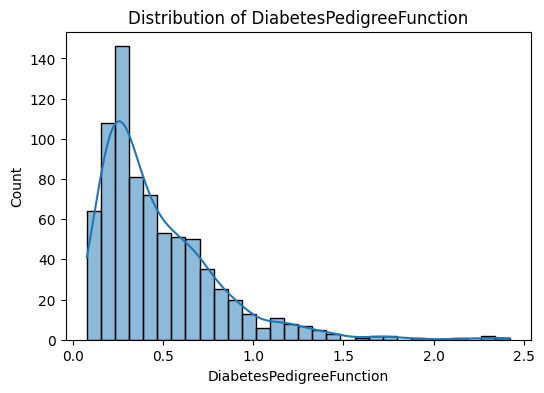

DiabetesPedigreeFunction — Shapiro-Wilk p-value: 0.0000 (Not Normal)


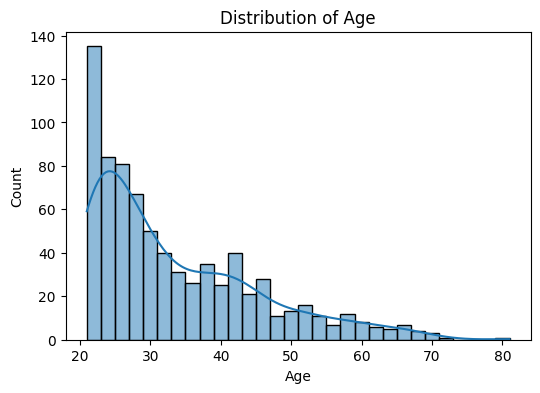

Age — Shapiro-Wilk p-value: 0.0000 (Not Normal)


In [15]:
# ---------------------------
# 2. DISTRIBUTION & NORMALITY CHECK
# ---------------------------
for col in df.columns[:-1]:  # exclude Outcome
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

    stat, p = stats.shapiro(df[col])
    print(f"{col} — Shapiro-Wilk p-value: {p:.4f} {'(Normal)' if p>0.05 else '(Not Normal)'}")


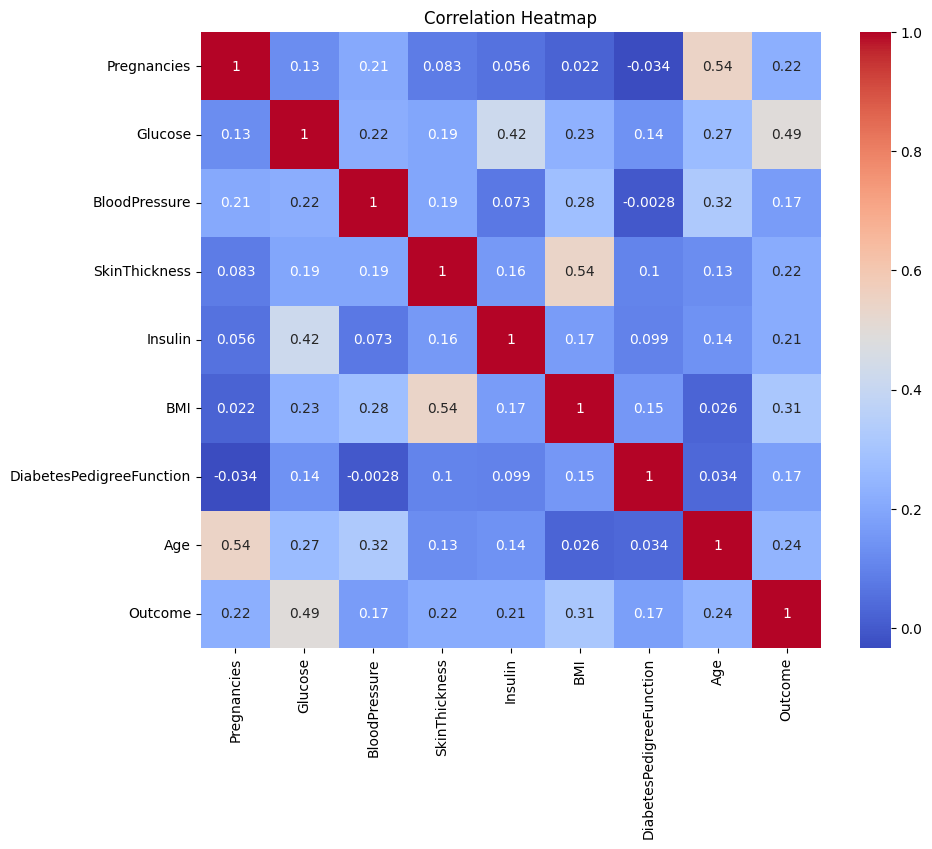


Correlation with Outcome:
Outcome                     1.000000
Glucose                     0.492928
BMI                         0.311924
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.215299
Insulin                     0.214411
DiabetesPedigreeFunction    0.173844
BloodPressure               0.166074
Name: Outcome, dtype: float64


In [16]:
# ---------------------------
# 3. CORRELATION MATRIX
# ---------------------------
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

print("\nCorrelation with Outcome:")
print(corr['Outcome'].sort_values(ascending=False))


In [17]:
# ---------------------------
# 4. GROUP COMPARISON (t-test or Mann-Whitney)
# ---------------------------
print("\nGroup Comparison Outcome 0 vs 1:")
outcome_0 = df[df['Outcome'] == 0]
outcome_1 = df[df['Outcome'] == 1]

for col in df.columns[:-1]:
    # Normality check
    pval_normality_0 = stats.shapiro(outcome_0[col])[1]
    pval_normality_1 = stats.shapiro(outcome_1[col])[1]
    # Use appropriate test
    if pval_normality_0 > 0.05 and pval_normality_1 > 0.05:
        stat, p = stats.ttest_ind(outcome_0[col], outcome_1[col])
        test_name = 't-test'
    else:
        stat, p = stats.mannwhitneyu(outcome_0[col], outcome_1[col])
        test_name = 'Mann-Whitney U'
    print(f"{col}: {test_name} p-value = {p:.4f}")



Group Comparison Outcome 0 vs 1:
Pregnancies: Mann-Whitney U p-value = 0.0000
Glucose: Mann-Whitney U p-value = 0.0000
BloodPressure: Mann-Whitney U p-value = 0.0000
SkinThickness: Mann-Whitney U p-value = 0.0000
Insulin: Mann-Whitney U p-value = 0.0000
BMI: Mann-Whitney U p-value = 0.0000
DiabetesPedigreeFunction: Mann-Whitney U p-value = 0.0000
Age: Mann-Whitney U p-value = 0.0000


In [18]:
# ---------------------------
# 5. EFFECT SIZE (Cohen's d) & ODDS RATIOS
# ---------------------------
def cohens_d(x, y):
    nx = len(x); ny = len(y)
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / pooled_std

print("\nEffect Sizes (Cohen's d):")
for col in df.columns[:-1]:
    d = cohens_d(outcome_1[col], outcome_0[col])
    print(f"{col}: d = {d:.3f}")

# Example Odds Ratio: BMI >= 30
df['High_BMI'] = (df['BMI'] >= 30).astype(int)
ct = pd.crosstab(df['High_BMI'], df['Outcome'])
odds_ratio = (ct.loc[1,1] / ct.loc[1,0]) / (ct.loc[0,1] / ct.loc[0,0])
print(f"\nOdds Ratio (BMI >=30 → Diabetes): {odds_ratio:.2f}")



Effect Sizes (Cohen's d):
Pregnancies: d = 0.477
Glucose: d = 1.187
BloodPressure: d = 0.353
SkinThickness: d = 0.462
Insulin: d = 0.460
BMI: d = 0.688
DiabetesPedigreeFunction: d = 0.370
Age: d = 0.514

Odds Ratio (BMI >=30 → Diabetes): 4.27


In [19]:
# ---------------------------
# 6. LOGISTIC REGRESSION BASED FEATURE IMPORTANCE
# ---------------------------
X = df.drop(columns=['Outcome'])
y = df['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

importance = pd.Series(model.coef_[0], index=df.columns[:-1])
print("\nLogistic Regression Coefficients (standardized):")
print(importance.sort_values(ascending=False))



Logistic Regression Coefficients (standardized):
Glucose                     1.123640
Pregnancies                 0.399364
BMI                         0.392377
Outcome                     0.349290
DiabetesPedigreeFunction    0.285674
Age                         0.163370
SkinThickness               0.021648
Insulin                    -0.072555
BloodPressure              -0.094686
dtype: float64


In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop(columns=['Outcome'])
X = X.loc[:, X.std() > 1e-8]  # remove constant features first

# Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Drop high-VIF (>10) features to reduce multicollinearity
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"]
X_reduced = X.drop(columns=high_vif_features)

# Fit logistic regression with reduced features
df_reduced = pd.concat([X_reduced, df["Outcome"]], axis=1)
logit_model = logit("Outcome ~ " + " + ".join(df_reduced.columns[:-1]), data=df_reduced).fit()
print(logit_model.summary())


                    feature        VIF
0               Pregnancies   3.297047
1                   Glucose  21.922281
2             BloodPressure  34.768176
3             SkinThickness  17.389604
4                   Insulin   5.371323
5                       BMI  50.664984
6  DiabetesPedigreeFunction   3.159475
7                       Age  14.406061
8                  High_BMI   5.170292
Optimization terminated successfully.
         Current function value: 0.552894
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      763
Method:                           MLE   Df Model:                            4
Date:                Tue, 12 Aug 2025   Pseudo R-squ.:                  0.1452
Time:                        00:39:34   Log-Likelihood:                -424.62
converged:                       T

In [21]:
logit_model = logit("Outcome ~ " + " + ".join(df.columns[:-1]), data=df).fit_regularized()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.013406661844377e-12
            Iterations: 48
            Function evaluations: 62
            Gradient evaluations: 48


In [22]:
# Optional: Statsmodels for Odds Ratios
# logit_model = logit("Outcome ~ " + " + ".join(df.columns[:-1]), data=df).fit()
print(logit_model.summary())
odds_ratios = np.exp(logit_model.params)
print("\nOdds Ratios:")
print(odds_ratios)


                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      758
Method:                           MLE   Df Model:                            9
Date:                Tue, 12 Aug 2025   Pseudo R-squ.:                   1.000
Time:                        00:39:34   Log-Likelihood:            -7.7830e-10
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                4.381e-208
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -10.1801    4.1e+05  -2.48e-05      1.000   -8.03e+05    8.03e+05
Pregnancies                  0.0476   2.45e+04   1.94e-06      1.000    -4.8e+04     4.8e